# **Forecasting Crypto Portfolios Like a Quant**

# Setup

For this lab, we will be using the following libraries:

*   [`pandas`] for managing the data.
*   [`numpy`] for mathematical operations.
*   [`sklearn`] for machine learning and machine-learning-pipeline related functions.
*   [`seaborn`]for visualizing the data.
*   [`matplotlib`]for additional plotting tools.

## *Installing Required Libraries*

In [1]:
!pip install tqdm pmdarima


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## *Importing Required Libraries*

In [3]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from os import listdir, getcwd
from os.path import isfile, join, basename
from pmdarima import auto_arima
from tqdm import tqdm
from zipfile import ZipFile
from typing import Awaitable
import asyncio
import numpy as np
import pandas as pd
import glob
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
def warn(*args, **kwargs):
    pass # Suppress warnings generated by your code
warnings.warn = warn
warnings.filterwarnings('ignore')

## *Importing Required Datasets*

_This section will download and unzip the datasets:_

In [5]:
import requests, zipfile, io

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0R8TEN/labs/data/cryptocurrency.zip"

# Download the zip file
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# Extract all files into current directory
z.extractall()

print("Dataset downloaded and extracted successfully.")


Dataset downloaded and extracted successfully.


## *Defining Helper Functions*

_Use this section to define any helper functions to help the notebook's code readability:_

In [6]:
def read_date_series_files(files, strat_time, end_time, join_type, col_read=None):
    folder = glob.glob(files)  # get files name
    dfs = pd.DataFrame(pd.date_range(start=strat_time, end=end_time, freq="d"), columns=["Date"])

    if join_type == "left":  # combine different columns from different files
        for f in folder:
            df = pd.read_csv(f, sep=",", header=0, usecols=col_read)
            df["Date"] = pd.to_datetime(df["Date"])
            dfs = dfs.merge(df, how=join_type, left_on="Date", right_on="Date")
            dfs = dfs.set_axis([*dfs.columns[:-1], basename(f).replace(".csv", "")], axis=1)

    elif join_type == "normal":  # combine same columns from different files
        df = [pd.read_csv(f, sep=",", header=0, usecols=col_read) for f in folder]
        dfs = pd.concat(df, ignore_index=True)
        dfs["Date"] = pd.to_datetime(dfs["Date"])

    dfs.set_index("Date", inplace=True)  # make the date become the index
    dfs = dfs.sort_index()
    return dfs


def find_first_date(df, display=False):
    global start_date, end_date
    i = df.isnull().sum().max()
    start_date = df.index[i]
    end_date = df.index[-1]
    if display:
        print("The first date in this time series is: ", start_date, "\n The last date in this time series is: ", end_date)


def clean_data(tv, pv):
    df1, df2 = tv.copy(), pv.copy()
    
    find_first_date(tv, True)
    df1 = df1[start_date:]

    df2 = df2[start_date:]
    df2.drop(["4 Mo"], axis=1, inplace=True)
    # fill missing datetime with previous day's values
    df2 = df2.reindex(pd.date_range(start_date, end_date)).reset_index().rename(columns={"index": "Date"})
    df2 = df2.groupby(df2["Date"].dt.time).ffill()
    df2.set_index("Date", inplace=True)
    return df1, df2


def prepare_data(dataset):
    df = dataset.copy()
    
    # normalized the data with min-max scaling
    df_nor = pd.DataFrame(MinMaxScaler().fit_transform(df)).assign(label=df.index)
    df_nor.columns = df.columns.to_list() + ["Date"]
    df_nor.set_index("Date", inplace=True)
    
    # we will remove the weak corellation (% between -0.2 to 0.2)
    cor = df_nor.corr(method="pearson")
    df_nor.drop(df_nor.columns[(cor.Index >= -0.2) & (cor.Index <= 0.2)], axis=1, inplace=True)
    return df_nor


def time_series_split(df, train_percent):
    train_size = int(len(df) * train_percent)
    predictor_train, target_train = pd.DataFrame(df.iloc[:train_size, :-1]), pd.DataFrame(df.iloc[:train_size, -1])
    predictor_test, target_test = pd.DataFrame(df.iloc[train_size:, :-1]), pd.DataFrame(df.iloc[train_size:, -1])
    return predictor_train, predictor_test, target_train, target_test


def decompose(df, period):
    decomposition = seasonal_decompose(df, model="additive", period=period)

    fig, axs = plt.subplots(4, 1, figsize=(18, 18))
    # original time series
    axs[0].plot(decomposition.observed)
    axs[0].set_title("Original Series", size=15)
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(7))
    # trend
    axs[1].plot(decomposition.trend)
    axs[1].set_title("Trend", size=15)
    axs[1].xaxis.set_major_locator(plt.MaxNLocator(7))
    # seasonal
    axs[2].plot(decomposition.seasonal)
    axs[2].set_title("Seasonal", size=15)
    axs[2].xaxis.set_major_locator(plt.MaxNLocator(7))
    # residual
    axs[3].plot(decomposition.resid)
    axs[3].set_title("Residual", size=15)
    axs[3].xaxis.set_major_locator(plt.MaxNLocator(7))
    plt.show()


def stationary(df):
    ori_df = df  # original time series
    fir_df = df.diff().dropna()  # first difference time series
    sec_df = df.diff().diff().dropna()  # second difference time series
    stationary_test = None

    fig, axs = plt.subplots(3, 3, figsize=(21, 9))
    for i in range(3):
        if i == 0:
            print("Original Time Series")
            stationary_test = adfuller(ori_df)
            axs[i, 0].plot(ori_df)
            axs[i, 0].set_title("Original Time Series")
            axs[i, 0].label_outer()
            plot_acf(ori_df, ax=axs[i, 1])
            plot_pacf(ori_df, ax=axs[i, 2])
        elif i == 1:
            print("First Order Differencing")
            stationary_test = adfuller(fir_df)
            axs[i, 0].plot(fir_df)
            axs[i, 0].set_title("First Order Differencing")
            axs[i, 0].label_outer()
            plot_acf(fir_df, ax=axs[i, 1])
            plot_pacf(fir_df, ax=axs[i, 2])
        elif i == 2:
            print("Second Order Differencing")
            stationary_test = adfuller(sec_df)
            axs[i, 0].plot(sec_df)
            axs[i, 0].set_title("Second Order Differencing")
            axs[i, 0].label_outer()
            plot_acf(sec_df, ax=axs[i, 1])
            plot_pacf(sec_df, ax=axs[i, 2])

        print("ADF Statistic: %f" %stationary_test[0])
        print("p-value: %f\n" %stationary_test[1])

    # hide x and tick labels
    for ax in axs.flat:
        ax.label_outer()
    plt.show()


# create empty folder
! mkdir my_crypto

A subdirectory or file my_crypto already exists.


# Loading Datasets

First, let's get the closing price of each cryptocurrency since 2010 using the function <code>read_date_series_files</code>. In this guided project, we will use 8 different cryptocurrencies that include Bitcoin, Binance Coin, Dogecoin, Ethereum, USD Coin, Tether, XRP, and the FTX Token.

In [7]:
path = str(getcwd() + "/cryptocurrency/coins/*.csv")
cryptos = read_date_series_files(path, "2010-08-01", "2022-11-15", "left", ["Date", "Close"])

cryptos.tail(3)

,bnb,btc,doge,eth,ftx,usdc,usdt,xrp
Date,,,,,,,,
2022-11-13,279.372157,16349.997597,0.084762,1223.796978,1.491613,1.00010,0.998967,0.340153
2022-11-14,278.798441,16630.637464,0.085818,1242.592693,1.493649,1.00000,0.999167,0.374665
2022-11-15,277.250100,16894.926500,0.086965,1252.796100,1.841371,0.99995,0.998983,0.388356


Now we need to find out some **"predictor variables"** or external factors that might affect the price of the cryptocurrencies.

First, let us get the Daily Treasury Par Yield Curve Rates from the U.S. Department of the Treasury starting in 2018.


In [8]:
path = str(getcwd() + "/cryptocurrency/interest_rate/*.csv")
rates = read_date_series_files(path, "2018-01-01", "2022-11-15", "normal")

rates.tail(3)

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,4 Mo
Date,,,,,,,,,,,,,
2022-11-10,3.71,4.00,4.28,4.52,4.59,4.34,4.17,3.95,3.89,3.82,4.24,4.03,4.36
2022-11-14,3.72,4.05,4.34,4.55,4.63,4.40,4.24,4.00,3.95,3.88,4.28,4.07,4.38
2022-11-15,3.77,4.10,4.31,4.54,4.60,4.37,4.17,3.93,3.88,3.80,4.20,3.98,4.40


We can also add some popular economic indicators like CPI or PSR as our predictor variables. But be aware that the following data time sequence is monthly based.


In [9]:
path = str(getcwd() + "/cryptocurrency/economic_index/*.csv")
economic_index = read_date_series_files(path, "2018-01-01", "2022-11-15", "left", ["Date", "Rate"])

economic_index.tail(3)

,consumer-price-index,personal-saving-rate
Date,,
2022-11-13,NaN,NaN
2022-11-14,NaN,NaN
2022-11-15,NaN,NaN


The last piece of our predictor variables will be the indices from the stock market: S&P 500 and Nasdaq, and the two command metals that trade in the market: gold and silver.


In [10]:
path = str(getcwd() + "/cryptocurrency/stock_index/*.csv")
stock_index = read_date_series_files(path, "2018-01-01", "2022-11-15", "left", ["Date", "Price"])

stock_index.tail(3)

,nasdaq,s&p500
Date,,
2022-11-13,NaN,NaN
2022-11-14,11196.22,3957.25
2022-11-15,11358.41,3991.73


In [11]:
path = str(getcwd() + "/cryptocurrency/metals/*.csv")
metals = read_date_series_files(path, "2018-01-01", "2022-11-15", "left", ["Date", "Price"])

metals.tail(3)

,gold,silver
Date,,
2022-11-13,NaN,NaN
2022-11-14,1771.80,21.97
2022-11-15,1778.25,21.54


Let us put all the predictor variables into one table, and then we can start cleaning and preparing the dataset. In this step, we will use the function <code>clean_data</code> to help us achieve it

In [12]:
# put all external factors together
find_first_date(cryptos)
predictor_variables = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq="d"), columns=["Date"])
predictor_variables = pd.concat([economic_index, stock_index, metals, rates], join="outer", axis=1)

In [13]:
coins, factors = clean_data(cryptos, predictor_variables)

The first date in this time series is:  2019-08-01 00:00:00 
 The last date in this time series is:  2022-11-15 00:00:00


Here we can better visualize cryptos and economic factors, but you should also notice that the scaling between each variable is extreme. We will deal with this problem in the next section.


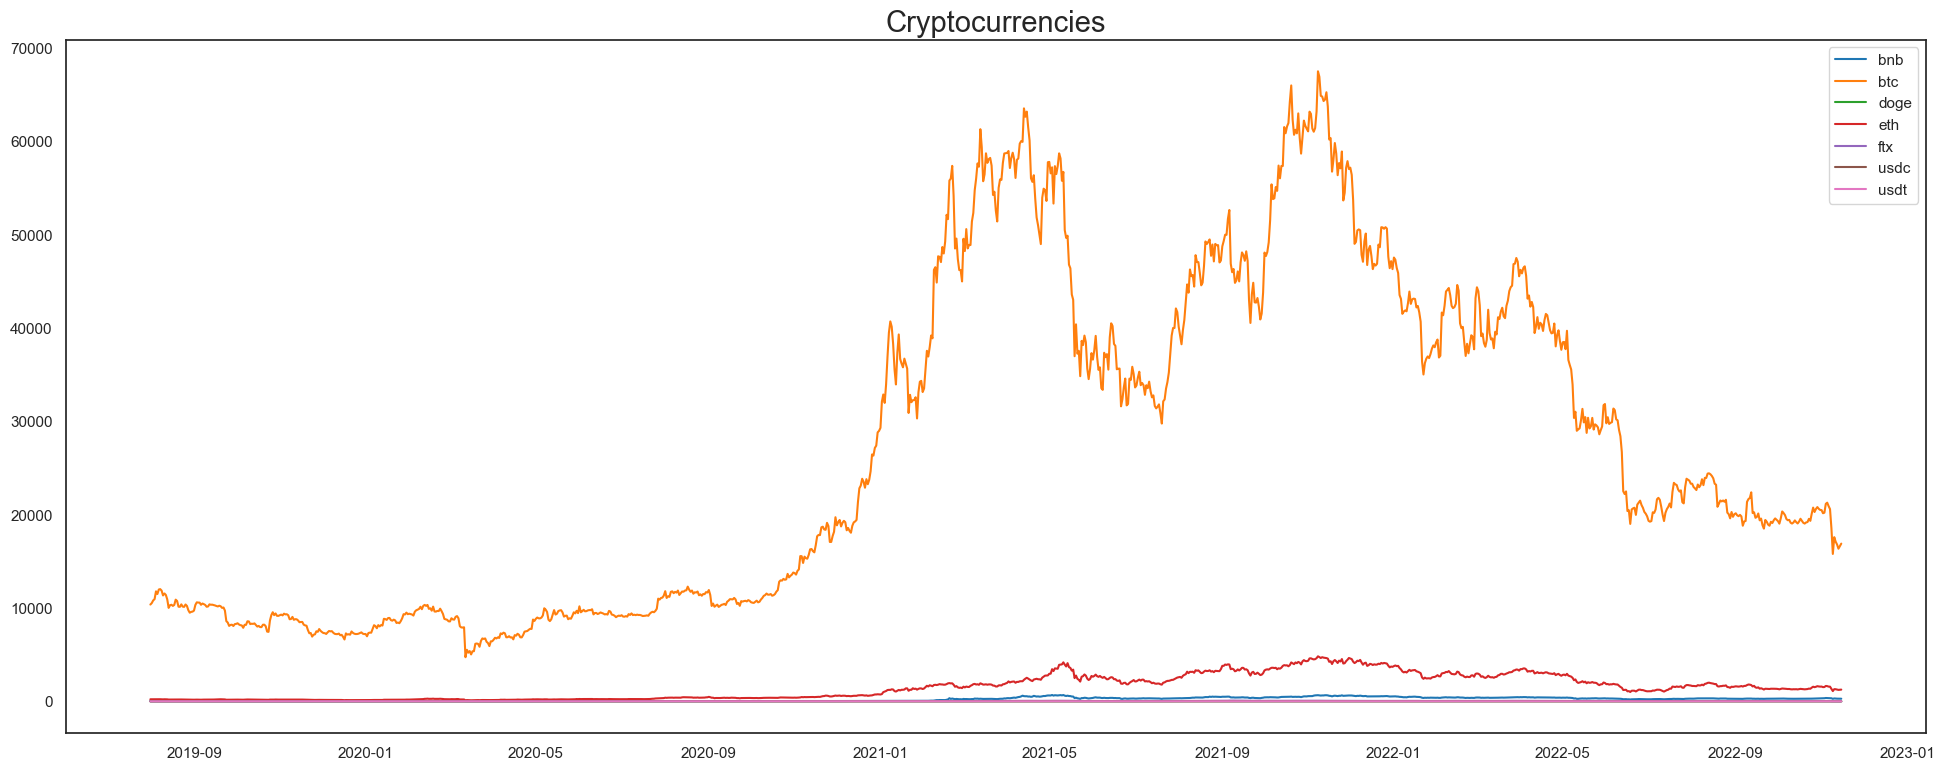

In [14]:
plt.figure(figsize=(24, 9))
for i in range(0, 7):
    plt.plot(coins.index, coins.iloc[:, i], label=coins.columns[i])

plt.title("Cryptocurrencies", fontsize=21)
plt.legend()
plt.show()

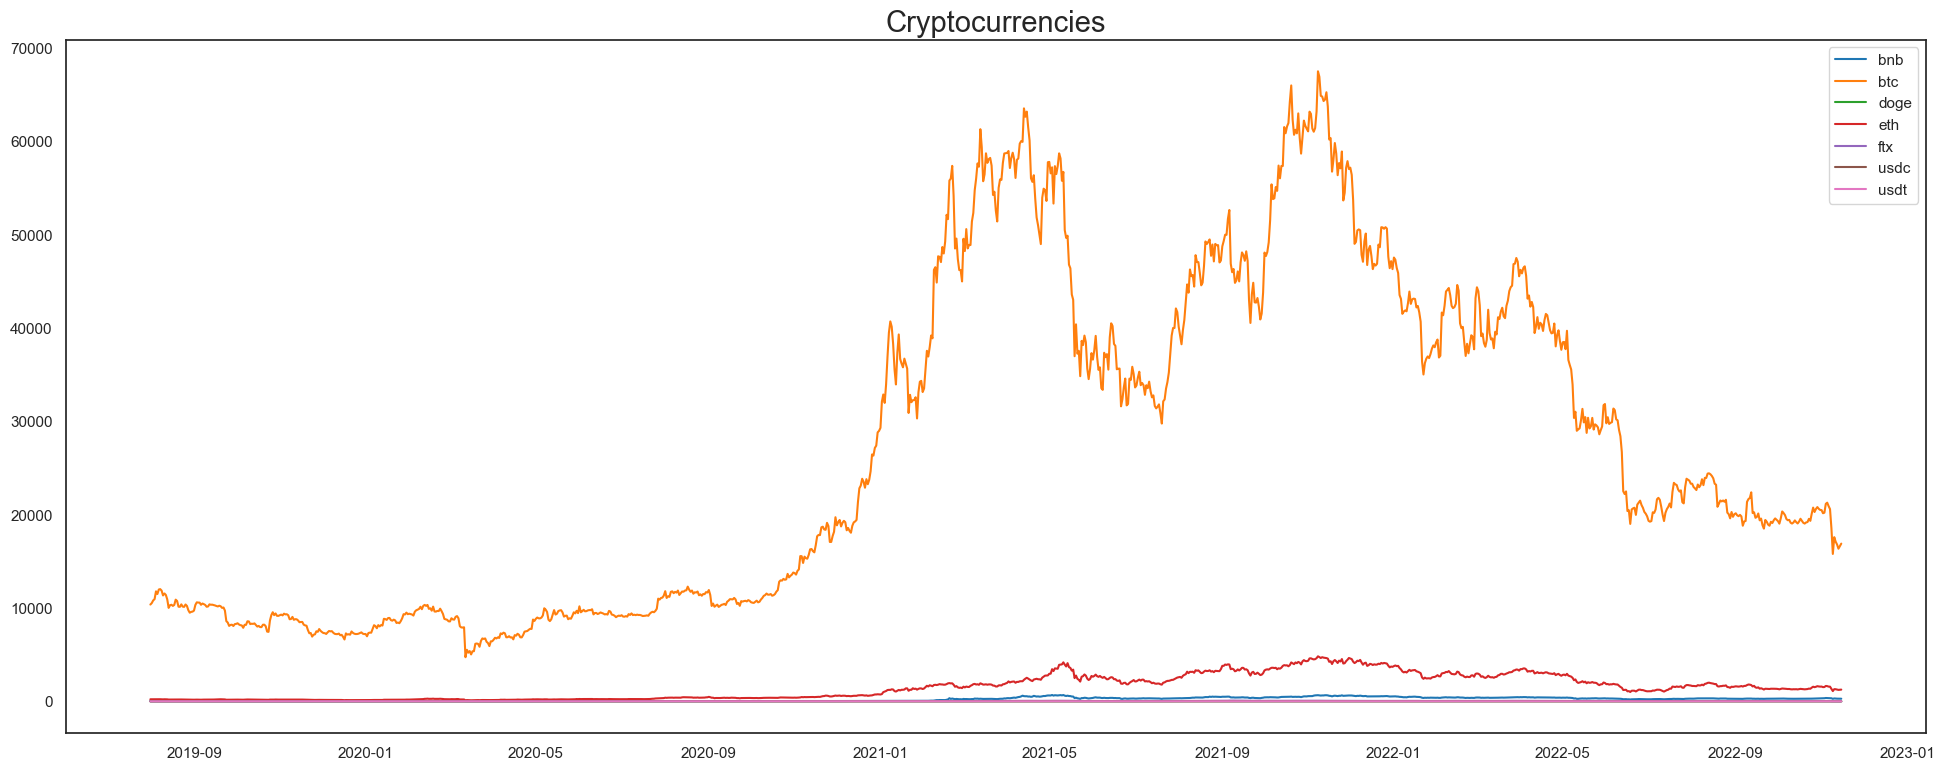

In [15]:
plt.figure(figsize=(24, 9))
for i in range(0, 7):
    plt.plot(coins.index, coins.iloc[:, i], label=coins.columns[i])

plt.title("Cryptocurrencies", fontsize=21)
plt.legend()
plt.show()

# Creating Customize Index

In [16]:
result = []

# calculate the index value
for i in range(len(coins.columns)):
    coin = coins[coins.columns[i]] / len(coins.columns)
    result.append(coin)
# assign index value with date
ew_index = pd.DataFrame(1 + pd.DataFrame(pd.concat(result, axis=1)).sum(axis=1))
ew_index = pd.DataFrame(1 + pd.concat(result, axis=1).sum(axis=1))
ew_index.columns = ["Index"]   # directly rename column
ew_index.tail(3)


,Index
Date,
2022-11-13,2233.135291
2022-11-14,2270.497737
2022-11-15,2304.661041


Here we can use <code>seaborn</code> package to view each month's interquartile range of the index.


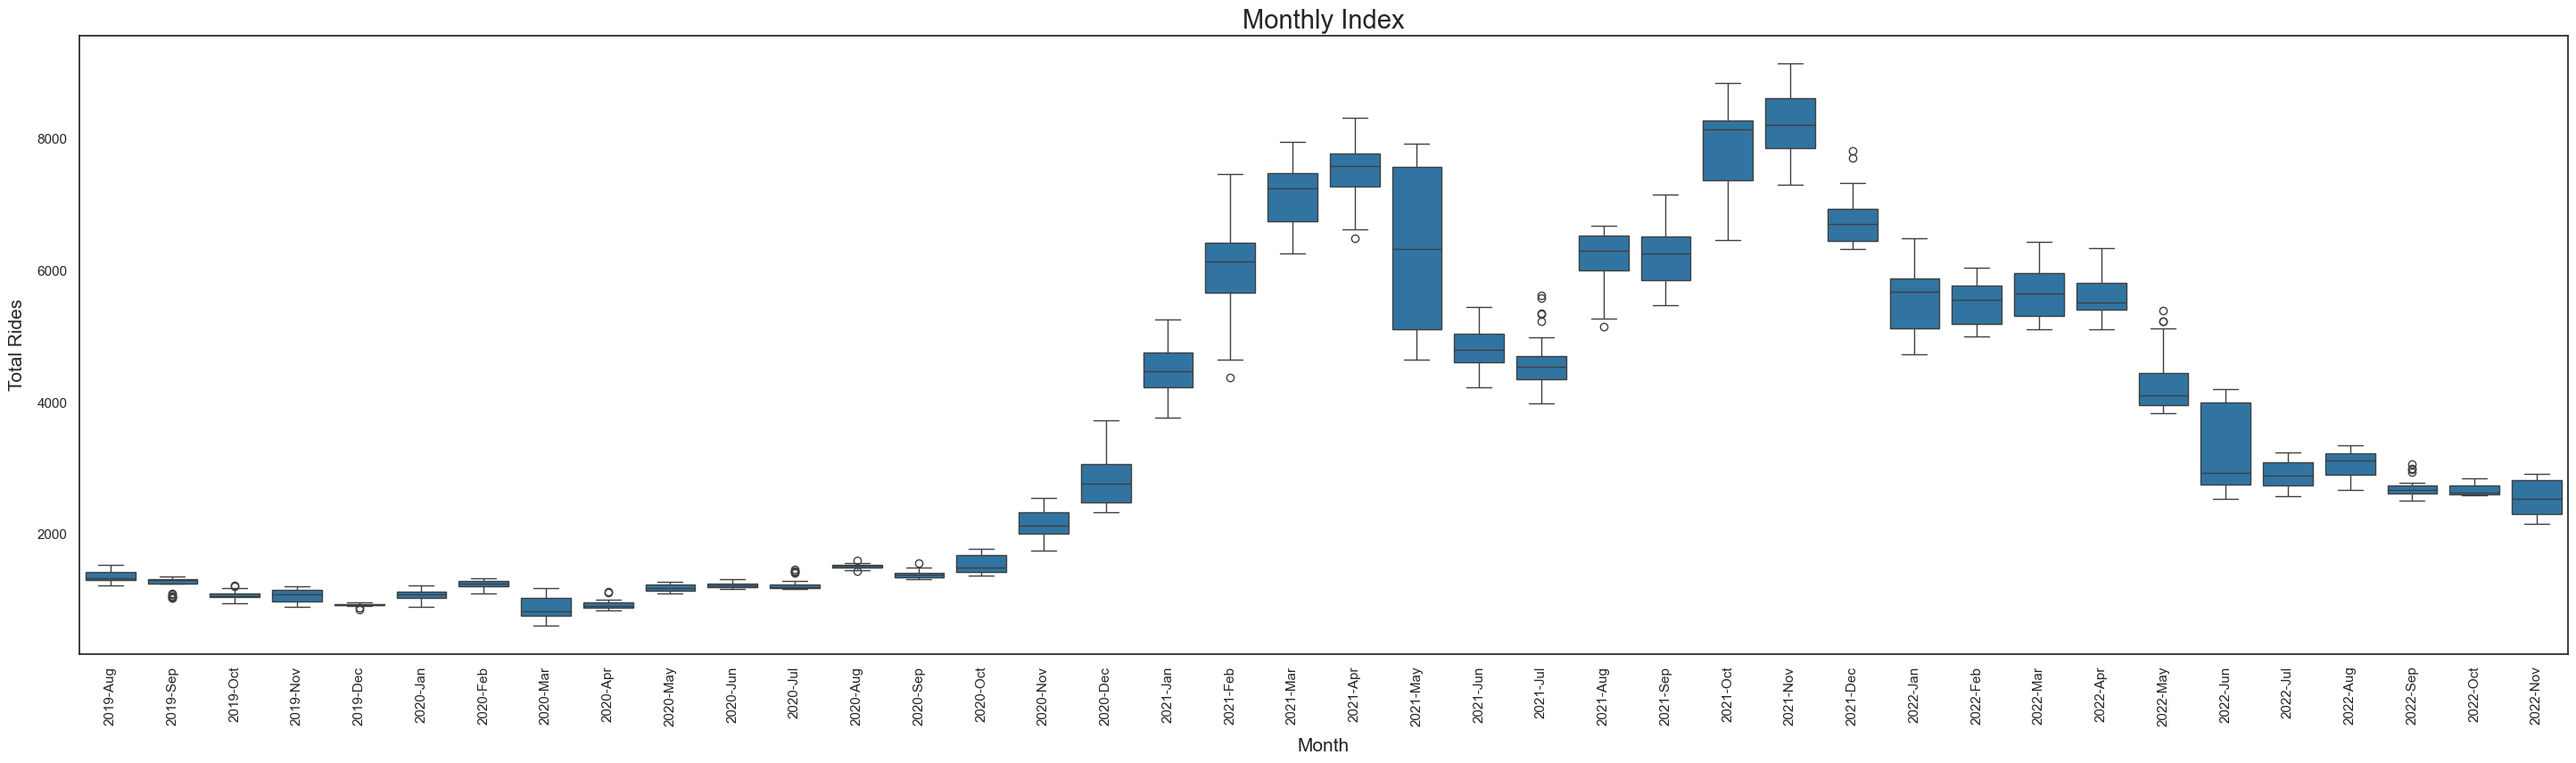

In [17]:
ts_fig, ts_ax = plt.subplots(figsize=(36, 9))
sns.boxplot(x=ew_index.index.strftime("%Y-%b"), y=ew_index.Index, ax=ts_ax)
ts_ax.set_xlabel("Month", labelpad=9, fontsize=15)
ts_ax.set_ylabel("Total Rides", labelpad=9, fontsize=15)
ts_ax.set_xticklabels(ts_ax.get_xticklabels(), rotation=90)
ts_ax.set_title("Monthly Index", fontsize=21)
plt.show()

Before we train the index data, we have to normalize the data and check the correlation between the target and predictor variables.

In [18]:
data = factors.merge(ew_index, how="left", left_on="Date", right_on="Date")

In [19]:
data_nor = prepare_data(data)

data_nor.tail(3)

,consumer-price-index,personal-saving-rate,nasdaq,s&p500,gold,silver,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,Index
Date,,,,,,,,,,,,
2022-11-13,1.0,0.003247,0.485242,0.685979,0.529585,0.564939,0.981481,0.975610,0.986175,0.978261,0.955882,0.190801
2022-11-14,1.0,0.003247,0.471421,0.672037,0.531367,0.581829,0.984127,0.987805,1.000000,0.984783,0.964286,0.195183
2022-11-15,1.0,0.003247,0.489056,0.685510,0.541718,0.556785,0.997354,1.000000,0.993088,0.982609,0.957983,0.199191


# Time Series Forecasting

## *What Is Time Series*

Time series is a numerical sequence of observations on an event taken sequentially in time and consists of two essential elements: time and value. The time element can be any time period like annually, quarterly, monthly, daily, hourly, or every minute. Yet, the most important thing is that the interval between the observations must be constant. The value element can be any observation, like hourly detection from a temperature sensor or a company's annual sales. For example, the time series of sales of a grocery store below is a period time series, which counts the total sales of the grocery store for each year within a one-year period.

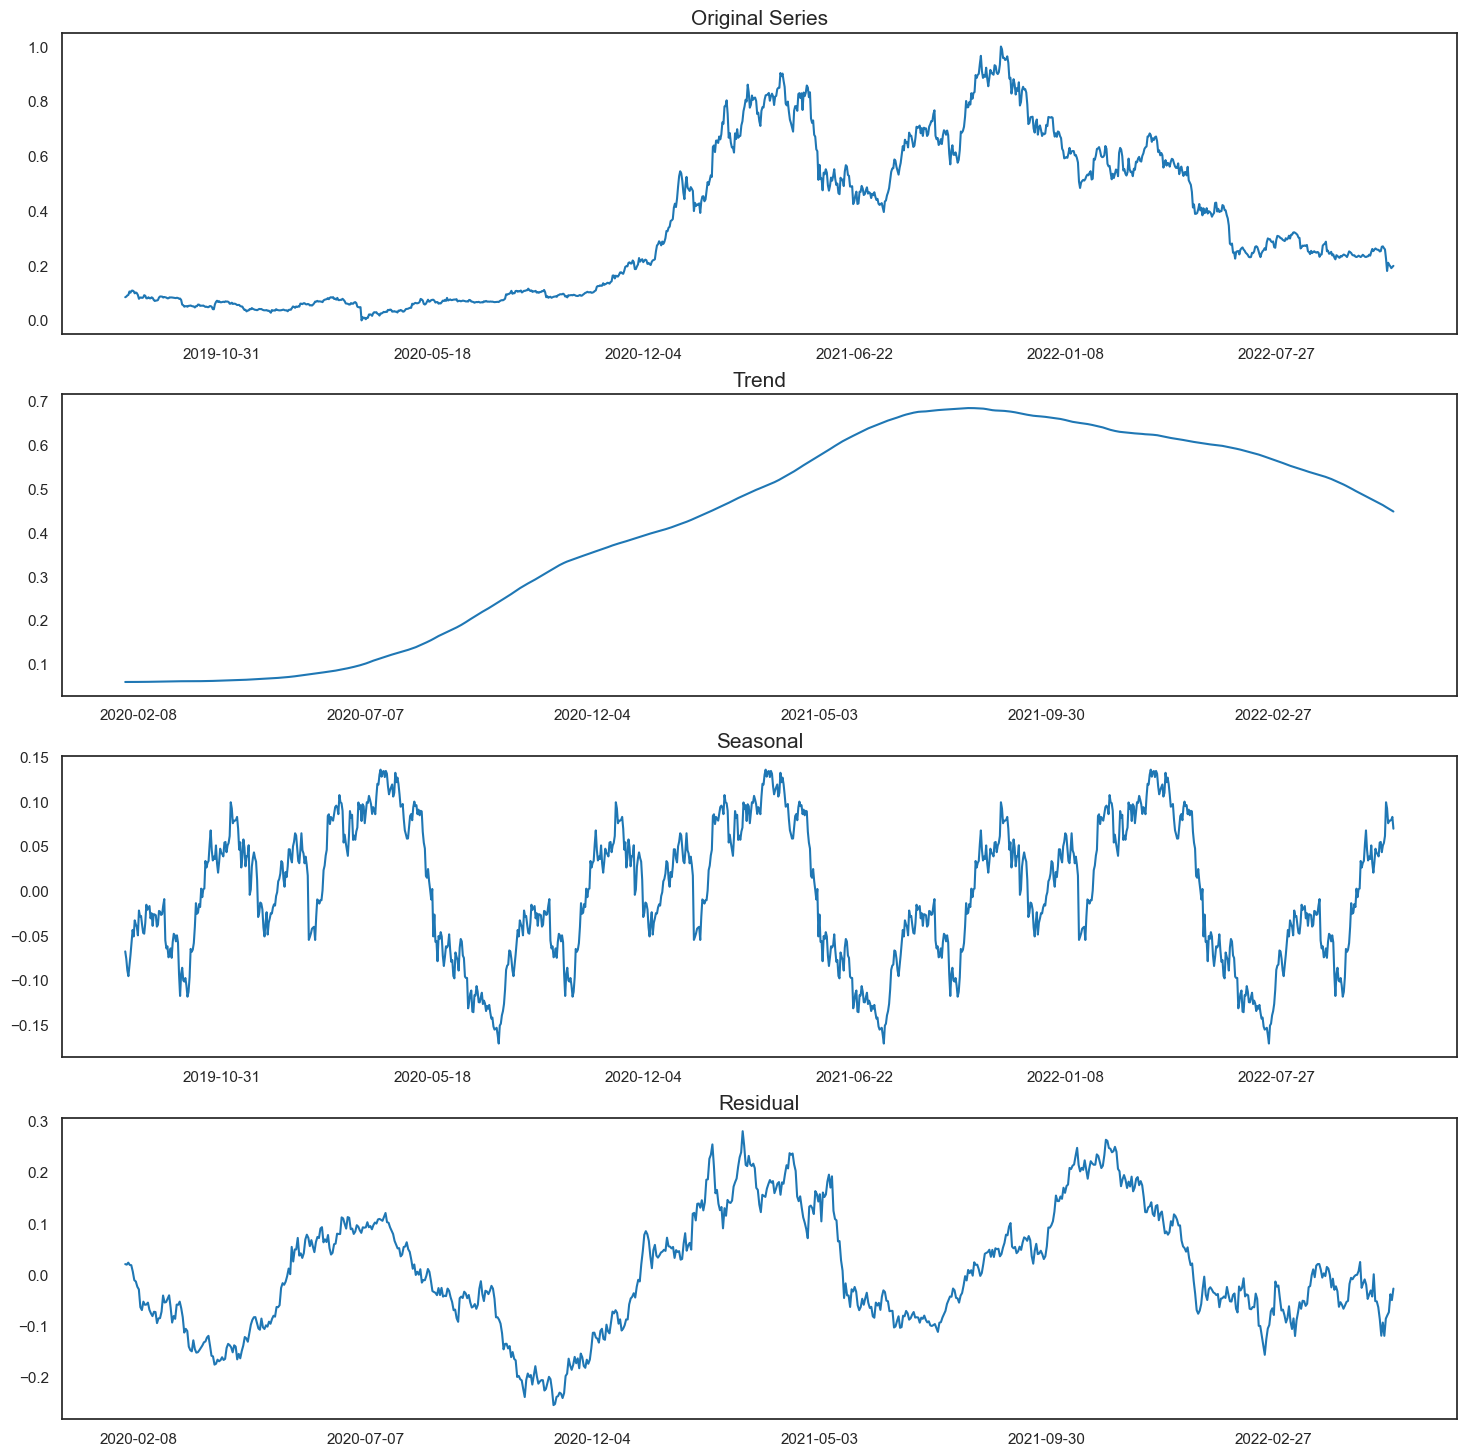

In [20]:
decompose(data_nor.Index, 365)

## *Training and Testing Sets*

In [21]:
X_train, X_test, y_train, y_test = time_series_split(data_nor, 0.9505)

## *Implementing ARIMA Model*

One of the models we are about to use to predict our time series data is called Autoregressive Integrated Moving Average (**ARIMA**). As we can see from the name, this is a model made by two other models: autoregressive and moving average models. In this section, we will demonstrate how to use ARIMA models by adjusting the parameters in Python.

As we known, there are 3 parameters that we can tune for the ARIMA model: `p`, `d`, `q`:

- $p$: stands for the number of past observations need to be included.

- $d$: stands for the number of differencing on observations to make a time series stationary.

- $q$: stands for the number of errors terms need to be included.


To find out the best parameters that suit our model. In this step, we will use one of the most powerful tools called `auto_arima` to help us find the p and q. We don't need to find d through this tool because we can use the stationary test to easily identify the order of differencing. You can find more information here to learn more about differencing: <a href="#How-To-Determine-Parameters-d?-Stationary-Detection">How To Determine Parameters d? Stationary Detection</a>

In this stage, we will set the parameter `d` at 1 and seasonal to __False__.

In [22]:
arima_param = auto_arima(y_train, start_p=1, d=1, start_q=1, max_p=5, max_q=5, trace=True, seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5753.803, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5756.672, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5755.802, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5755.797, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5758.612, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.408 seconds


Based on the result, we found that the best parameters for ARIMA models are when `p` and `q` equal 0. Then we can put these parameters into the model and start to train our model. In this stage, we will put the training dataset into the `ARIMA` and the parameters we got from `auto_arima` into `order`.


In [23]:
algorithm = ARIMA(y_train, order=arima_param.get_params()["order"])
model = algorithm.fit()

Finally, we can use the trained model to predict the testing data. Here we need to set the `steps` parameter as the length of the testing data. Then we can check the error rate of the model to ensure the model's performance.


In [24]:
from sklearn.metrics import mean_squared_error
import numpy as np

# forecast the data
forecast = model.get_forecast(steps=len(y_test))
prediction = forecast.predicted_mean
ci = forecast.conf_int()

# calculate error rates
mse = mean_squared_error(y_test, prediction)      # MSE
rmse = np.sqrt(mse)                               # RMSE

print("The error rates of the ARIMA forecasting are:")
print("MSE =", mse)
print("RMSE =", rmse)


The error rates of the ARIMA forecasting are:
MSE = 0.00039784681464411837
RMSE = 0.019946097729734463


compare the forecasting results with the reality in the plot.


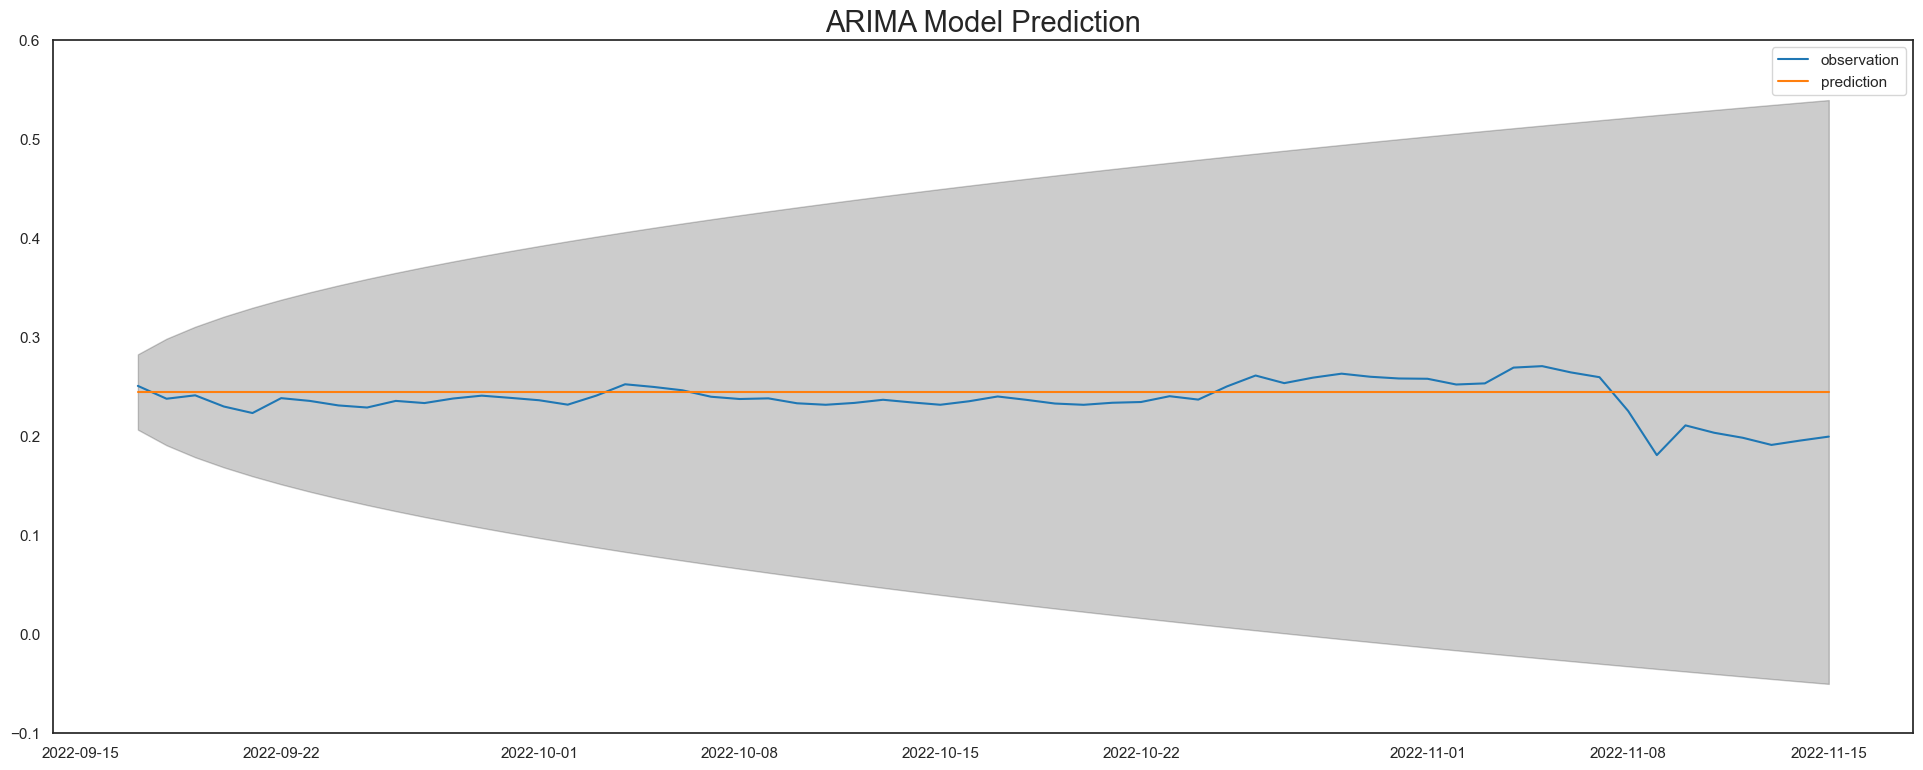

In [25]:
plt.figure(figsize=(24, 9))
plt.plot(y_test.index, y_test, label="observation")
plt.plot(prediction.index, prediction, label="prediction")
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="k", alpha=0.2)
plt.ylim([-0.1, 0.6])
plt.title("ARIMA Model Prediction", fontsize=21)
plt.legend()
plt.show()

As the result of the ARIMA model, the error rate for predicting the 2 months index values is relatively low, but when we look at the chart, we can tell the reason the error rate is low because the prediction is based on the average line of the index value and **omits the randomness in the forecasting**.


## *Implementing SARIMAX Model*

The SARIMAX model's function is similar to the ARIMA model but adds two other elements: seasonality and external factors.

The key takeaway is that SARIMAX requires not only the `p`, `d`, and `q` arguments that ARIMA requires, but it also requires another set of `P`, `D`, and `Q` arguments for the seasonality aspect as well as an argument called "`m`." It is the periodicity of the data's seasonal cycle; in other words, it is the number of periods in each season

In [26]:
sarimax_param = auto_arima(y_train, exogenous=X_train, m=7, start_p=0, d=1, start_q=0, start_P=0, D=1, start_Q=0, max_p=3, max_q=1, max_P=3, max_Q=1, trace=True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-4875.606, Time=0.33 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-5232.037, Time=0.61 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=2.14 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-4874.647, Time=0.22 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-5366.197, Time=1.27 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=-5467.987, Time=2.80 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=inf, Time=7.28 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=5.06 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=-5467.389, Time=0.66 sec
 ARIMA(2,1,0)(3,1,0)[7]             : AIC=-5466.166, Time=3.58 sec
 ARIMA(1,1,1)(3,1,0)[7]             : AIC=-5464.099, Time=3.46 sec
 ARIMA(0,1,1)(3,1,0)[7]             : AIC=-5467.917, Time=1.84 sec
 ARIMA(2,1,1)(3,1,0)[7]             : AIC=-5464.312, Time=3.96 sec
 ARIMA(1,1,0)(3,1,0)[7] intercept   : AIC=-5465.981, Time=4.41 sec

Best model:  ARIMA(1,1,0)(3,1,0)[7] 

Based on the result, we found that the best parameters for SARIMAX models are when `p` is 1, `q` is 0, `P` is 3, `Q` is 0. Then we can put these parameters into the model and start to train our model. In this stage, we will put the training dataset into the `SARIMAX` and the parameters we got from `auto_arima` into `order` and seasonal parameters into `seasonal_order`.


In [ ]:
algorithm = SARIMAX(endog=y_train, exog=X_train, order=sarimax_param.get_params()["order"], seasonal_order=sarimax_param.get_params()["seasonal_order"])
model = algorithm.fit(disp=False)

Finally, we can use the trained model to predict the testing data. Here we need to set the `start` and `end` parameters as the length of the testing data and put all the external factors in the `exog` parameter. Then we can check the error rate of the model to ensure the model's performance.


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# forecast the data
forecast = model.get_prediction(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test, dynamic=True)
prediction = forecast.predicted_mean
ci = forecast.conf_int()

# calculate error rates
mse = mean_squared_error(y_test, prediction)  # MSE
rmse = np.sqrt(mse)                           # RMSE

print("The error rates of the SARIMAX forecasting are:")
print("MSE =", mse)
print("RMSE =", rmse)


compare the forecasting results with the reality in the plot.


In [ ]:
plt.figure(figsize=(24, 9))
plt.plot(y_test.index, y_test, label="observation")
plt.plot(prediction.index, prediction, label="prediction")
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="k", alpha=0.2)
plt.ylim([0.18, 0.3])
plt.title("SARIMAX Model Prediction", fontsize=21)
plt.legend()
plt.show()

As the result of the SARIMAX model, the error rate for predicting the 2 months index values is relatively low but a bit higher than the ARIMA model. It is because we not only capture the seasonality of the data but also include external factors like consumer price index value or stock market index price to support the SARIMAX model.